In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

df1 = pd.read_csv('tr_basic_cardl_20210101_20230630.csv') #롯데카드
df2 = pd.read_csv('tr_basic_cardh_20190101_20230630.csv') #하나카드
df3 = pd.read_csv('LIST_BT.csv') #종목코드

lottecard = df1[df1['mandata_brand_name'].isin(['HYUNDAI DEPARTMENT STORE CO LTD_ALL', 'LOTTE SHOPPING CO LTD_ALL'])]
hanacard = df2[df2['mandata_brand_name'].isin(['HYUNDAI DEPARTMENT STORE CO LTD_ALL', 'LOTTE SHOPPING CO LTD_ALL'])]

card_data = pd.merge(lottecard, hanacard, on=['transaction_date', 'mandata_brand_name'], how='outer')
card_data.to_csv('card_data_(hyundai,lotte).csv', index=False)

In [3]:
data = pd.read_csv('card_data_(hyundai,lotte).csv', parse_dates=['transaction_date'])
data['mon'] = data['transaction_date'].dt.month
data['year'] = data['transaction_date'].dt.year
monthly_data = data.groupby(['mandata_brand_name', 'year', 'mon']).agg({
    'sales_l': 'sum',
    'number_l': 'sum',
    'users_l': 'sum',
    'sales_h': 'sum',
    'number_h': 'sum',
    'users_h': 'sum'
}).reset_index()
yearly_data = data.groupby(['mandata_brand_name', 'year']).agg({
    'sales_l': 'sum',
    'number_l': 'sum',
    'users_l': 'sum',
    'sales_h': 'sum',
    'number_h': 'sum',
    'users_h': 'sum'
}).reset_index()
#monthly_data['sales_all_month'] = monthly_data['sales_l'] + monthly_data['sales_h']
monthly_data['sales_all_month'] = monthly_data['sales_h']
#yearly_data['sales_all_year'] = yearly_data['sales_l'] + yearly_data['sales_h']
yearly_data['sales_all_year'] = yearly_data['sales_h']
monthly_data = pd.merge(monthly_data, yearly_data[['mandata_brand_name', 'year', 'sales_all_year']], on=['mandata_brand_name', 'year'], how='left', suffixes=('', '_right'))

monthly_data.to_csv('sales_data_(hyundai,lotte).csv', index=False)

In [4]:
df = pd.read_csv('sales_data_(hyundai,lotte).csv')

#연매출비교
dfsaleyear = df.groupby(['year', 'mandata_brand_name'])['sales_all_year'].first().reset_index()
total_sales_by_year = dfsaleyear.groupby('year')['sales_all_year'].transform('sum')
dfsaleyear['yearly_ratio'] = dfsaleyear['sales_all_year'] / total_sales_by_year
yearly_ratio = dfsaleyear.copy()
yearly_ratio['year'] += 1

#월매출비교
dfsalemon = df.groupby(['year', 'mon', 'mandata_brand_name'])['sales_all_month'].sum().reset_index()
total_sales_by_mon_year = dfsalemon.groupby(['mon', 'year'])['sales_all_month'].sum()
dfsalemon['monthly_ratio'] = dfsalemon.apply(lambda row: row['sales_all_month'] / total_sales_by_mon_year.loc[(row['mon'], row['year'])], axis=1)
monthly_ratio = dfsalemon.copy()

for i in range(len(monthly_ratio)):
    year = monthly_ratio.loc[i, 'year']
    mon = monthly_ratio.loc[i, 'mon']
    name = monthly_ratio.loc[i, 'mandata_brand_name']
    
    yearly_ratio_value = yearly_ratio[(yearly_ratio['year'] == year) & (yearly_ratio['mandata_brand_name'] == name)]['yearly_ratio'].values
    monthly_ratio_value = monthly_ratio[(monthly_ratio['year'] == year) & (monthly_ratio['mon'] == mon) & (monthly_ratio['mandata_brand_name'] == name)]['monthly_ratio'].values

    if yearly_ratio_value.size > 0 and monthly_ratio_value.size > 0:
        if monthly_ratio_value[0] > yearly_ratio_value[0]:
            monthly_ratio.loc[i, 'active'] = 'buy'
        elif monthly_ratio_value[0] < yearly_ratio_value[0]:
            monthly_ratio.loc[i, 'active'] = 'sell'
        else:
            monthly_ratio.loc[i, 'active'] = 'hold'
    else:
        monthly_ratio.loc[i, 'active'] = 'no data'

monthly_ratio.to_csv('monthly_active_(hyundai,lotte).csv', index=False)

monthly_ratio = monthly_ratio[monthly_ratio['active'] != 'no data']
sell_previous = monthly_ratio[monthly_ratio['active'] == 'buy']
sell_current = monthly_ratio[monthly_ratio['active'] == 'sell']
merged = sell_current.merge(sell_previous, how='outer', indicator=True)
changed_rows = merged[merged['_merge'] == 'right_only']
changed_rows = changed_rows.drop(columns=['_merge'])

changed_rows.to_csv('table_(hyundai,lotte).csv', index=True)

In [5]:
h_close = pd.read_csv('h_close.csv', parse_dates=['transaction_date'])
l_close = pd.read_csv('l_close.csv', parse_dates=['transaction_date'])
close_hl = pd.merge(h_close, l_close[['transaction_date', 'Close']], on='transaction_date', how='left', suffixes=('_h', '_l'))
close_hl.to_csv('stock_data_(hyundai,lotte).csv', index=False)

In [6]:
close_hl = pd.read_csv('stock_data_(hyundai,lotte).csv', index_col='transaction_date', parse_dates=True)

start_date = '2020-01-31'
end_date = '2020-04-29'

sell_h = close_hl.loc[start_date:end_date].copy()  # 복사본 생성
sell_h.loc[:, 'close_h_return'] = sell_h['Close_h'].pct_change()
sell_h.loc[:, 'close_l_return'] = sell_h['Close_l'].pct_change()
sell_h.loc[:, 'close_h_return'] = sell_h['close_h_return'].ffill()
sell_h.loc[:, 'close_l_return'] = sell_h['close_l_return'].ffill()
sell_h.loc[:, 'cumulative_h_return'] = (1 + sell_h['close_h_return']).cumprod() - 1
sell_h.loc[:, 'cumulative_l_return'] = (1 + sell_h['close_l_return']).cumprod() - 1
sell_h.loc[:, 'h_return_sell'] = -sell_h['cumulative_h_return']

sell_h.loc[:, 'return'] = sell_h['cumulative_l_return'] + sell_h['h_return_sell']
sell_h.to_csv('close_hl1.csv', index=True)

print("롯데쇼핑 롱 누적수익률:", sell_h['cumulative_l_return'].iloc[-1]*100)
print("현대백화점 숏 누적수익률:", sell_h['h_return_sell'].iloc[-1]*100)
return1 = sell_h['return'].iloc[-1]  # 매매 누적수익률
print("매매 누적수익률:", return1*100)

롯데쇼핑 롱 누적수익률: -13.593073593073601
현대백화점 숏 누적수익률: 6.7948717948718045
매매 누적수익률: -6.798201798201797


In [7]:
start_date = '2020-04-29'
end_date ='2022-01-28'
sell_l = close_hl.loc[start_date:end_date].copy()

sell_l.loc[:, 'close_h_return'] = sell_l['Close_h'].pct_change()
sell_l.loc[:, 'close_l_return'] = sell_l['Close_l'].pct_change()
sell_l.loc[:, 'close_h_return'] = sell_l['close_h_return'].ffill()
sell_l.loc[:, 'close_l_return'] = sell_l['close_l_return'].ffill()
sell_l.loc[:, 'cumulative_h_return'] = (1 + sell_l['close_h_return']).cumprod() - 1
sell_l.loc[:, 'cumulative_l_return'] = (1 + sell_l['close_l_return']).cumprod() - 1
sell_l.loc[:, 'l_return_sell'] = -sell_l['cumulative_l_return']
sell_l.loc[:, 'return'] = sell_l['cumulative_h_return'] + sell_l['l_return_sell'] + return1
sell_l.to_csv('close_hl2.csv', index=True)

print("롯데쇼핑 숏 누적수익률:", sell_l['l_return_sell'].iloc[-1]*100)
print("현대백화점 롱 누적수익률:", sell_l['cumulative_h_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_l['return'].iloc[-1]*100)
return1 = sell_l['return'].iloc[-1]  # 매매 누적수익률

롯데쇼핑 숏 누적수익률: 20.140280561122314
현대백화점 롱 누적수익률: -1.650618982118457
매매 누적수익률: 11.69145978080206


In [8]:
start_date = '2022-01-28'
end_date = '2022-02-28'

sell_h = close_hl.loc[start_date:end_date].copy()  # 복사본 생성
sell_h.loc[:, 'close_h_return'] = sell_h['Close_h'].pct_change()
sell_h.loc[:, 'close_l_return'] = sell_h['Close_l'].pct_change()
sell_h.loc[:, 'close_h_return'] = sell_h['close_h_return'].ffill()
sell_h.loc[:, 'close_l_return'] = sell_h['close_l_return'].ffill()
sell_h.loc[:, 'cumulative_h_return'] = (1 + sell_h['close_h_return']).cumprod() - 1
sell_h.loc[:, 'cumulative_l_return'] = (1 + sell_h['close_l_return']).cumprod() - 1
sell_h.loc[:, 'h_return_sell'] = -sell_h['cumulative_h_return']

sell_h.loc[:, 'return'] = sell_h['cumulative_l_return'] + sell_h['h_return_sell'] +return1
sell_h.to_csv('close_hl3.csv', index=True)

print("롯데쇼핑 롱 누적수익률:", sell_h['cumulative_l_return'].iloc[-1]*100)
print("현대백화점 숏 누적수익률:", sell_h['h_return_sell'].iloc[-1]*100)
return1 = sell_h['return'].iloc[-1]  # 매매 누적수익률
print("매매 누적수익률:", return1*100)

return1 = sell_h['return'].iloc[-1]

롯데쇼핑 롱 누적수익률: 7.026348808030103
현대백화점 숏 누적수익률: -8.811188811188853
매매 누적수익률: 9.90661977764331


In [9]:
start_date = '2022-02-28'
end_date ='2022-08-31'
sell_l = close_hl.loc[start_date:end_date].copy()

sell_l.loc[:, 'close_h_return'] = sell_l['Close_h'].pct_change()
sell_l.loc[:, 'close_l_return'] = sell_l['Close_l'].pct_change()
sell_l.loc[:, 'close_h_return'] = sell_l['close_h_return'].ffill()
sell_l.loc[:, 'close_l_return'] = sell_l['close_l_return'].ffill()
sell_l.loc[:, 'cumulative_h_return'] = (1 + sell_l['close_h_return']).cumprod() - 1
sell_l.loc[:, 'cumulative_l_return'] = (1 + sell_l['close_l_return']).cumprod() - 1
sell_l.loc[:, 'l_return_sell'] = -sell_l['cumulative_l_return']

sell_l.loc[:, 'return'] = sell_l['cumulative_h_return'] + sell_l['l_return_sell'] + return1
sell_l.to_csv('close_hl4.csv', index=True)

print("롯데쇼핑 숏 누적수익률:", sell_l['l_return_sell'].iloc[-1]*100)
print("현대백화점 롱 누적수익률:", sell_l['cumulative_h_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_l['return'].iloc[-1]*100)

return1 = sell_l['return'].iloc[-1]

롯데쇼핑 숏 누적수익률: -15.826494724501838
현대백화점 롱 누적수익률: -20.437017994858707
매매 누적수익률: -26.356892941717234


In [10]:
start_date = '2022-08-31'
end_date = '2022-09-30'

sell_h = close_hl.loc[start_date:end_date].copy()  # 복사본 생성
sell_h.loc[:, 'close_h_return'] = sell_h['Close_h'].pct_change()
sell_h.loc[:, 'close_l_return'] = sell_h['Close_l'].pct_change()
sell_h.loc[:, 'close_h_return'] = sell_h['close_h_return'].ffill()
sell_h.loc[:, 'close_l_return'] = sell_h['close_l_return'].ffill()
sell_h.loc[:, 'cumulative_h_return'] = (1 + sell_h['close_h_return']).cumprod() - 1
sell_h.loc[:, 'cumulative_l_return'] = (1 + sell_h['close_l_return']).cumprod() - 1
sell_h.loc[:, 'h_return_sell'] = -sell_h['cumulative_h_return']

sell_h.loc[:, 'return'] = sell_h['cumulative_l_return'] + sell_h['h_return_sell'] + return1
sell_h.to_csv('close_hl5.csv', index=True)

print("롯데쇼핑 롱 누적수익률:", sell_h['cumulative_l_return'].iloc[-1]*100)
print("현대백화점 숏 누적수익률:", sell_h['h_return_sell'].iloc[-1]*100)
return1 = sell_h['return'].iloc[-1]  # 매매 누적수익률
print("매매 누적수익률:", return1*100)

return1 = sell_h['return'].iloc[-1]

롯데쇼핑 롱 누적수익률: -12.449392712550633
현대백화점 숏 누적수익률: 12.11631663974153
매매 누적수익률: -26.689969014526337


In [11]:
start_date = '2022-09-30'
end_date ='2022-10-31'
sell_l = close_hl.loc[start_date:end_date].copy()

sell_l.loc[:, 'close_h_return'] = sell_l['Close_h'].pct_change()
sell_l.loc[:, 'close_l_return'] = sell_l['Close_l'].pct_change()
sell_l.loc[:, 'close_h_return'] = sell_l['close_h_return'].ffill()
sell_l.loc[:, 'close_l_return'] = sell_l['close_l_return'].ffill()
sell_l.loc[:, 'cumulative_h_return'] = (1 + sell_l['close_h_return']).cumprod() - 1
sell_l.loc[:, 'cumulative_l_return'] = (1 + sell_l['close_l_return']).cumprod() - 1
sell_l.loc[:, 'l_return_sell'] = -sell_l['cumulative_l_return']
sell_l.loc[:, 'return'] = sell_l['cumulative_h_return'] + sell_l['l_return_sell'] + return1
sell_l.to_csv('close_hl6.csv', index=True)

print("롯데쇼핑 숏 누적수익률:", sell_l['l_return_sell'].iloc[-1]*100)
print("현대백화점 롱 누적수익률:", sell_l['cumulative_h_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_l['return'].iloc[-1]*100)

return1 = sell_l['return'].iloc[-1]

롯데쇼핑 숏 누적수익률: -1.0404624277456698
현대백화점 롱 누적수익률: -0.5514705882353033
매매 누적수익률: -28.28190203050731


In [12]:
start_date = '2022-10-31'
end_date = '2022-12-29'

sell_h = close_hl.loc[start_date:end_date].copy()  # 복사본 생성
sell_h.loc[:, 'close_h_return'] = sell_h['Close_h'].pct_change()
sell_h.loc[:, 'close_l_return'] = sell_h['Close_l'].pct_change()
sell_h.loc[:, 'close_h_return'] = sell_h['close_h_return'].ffill()
sell_h.loc[:, 'close_l_return'] = sell_h['close_l_return'].ffill()
sell_h.loc[:, 'cumulative_h_return'] = (1 + sell_h['close_h_return']).cumprod() - 1
sell_h.loc[:, 'cumulative_l_return'] = (1 + sell_h['close_l_return']).cumprod() - 1
sell_h.loc[:, 'h_return_sell'] = -sell_h['cumulative_h_return']

sell_h.loc[:, 'return'] = sell_h['cumulative_l_return'] + sell_h['h_return_sell'] + return1
sell_h.to_csv('close_hl7.csv', index=True)

print("롯데쇼핑 롱 누적수익률:", sell_h['cumulative_l_return'].iloc[-1]*100)
print("현대백화점 숏 누적수익률:", sell_h['h_return_sell'].iloc[-1]*100)
return1 = sell_h['return'].iloc[-1]  # 매매 누적수익률
print("매매 누적수익률:", return1*100)

return1 = sell_h['return'].iloc[-1]

롯데쇼핑 롱 누적수익률: 4.118993135011384
현대백화점 숏 누적수익률: -9.057301293900144
매매 누적수익률: -33.22021018939607


In [13]:
start_date = '2022-12-29'
end_date ='2023-01-31'
sell_l = close_hl.loc[start_date:end_date].copy()

sell_l.loc[:, 'close_h_return'] = sell_l['Close_h'].pct_change()
sell_l.loc[:, 'close_l_return'] = sell_l['Close_l'].pct_change()
sell_l.loc[:, 'close_h_return'] = sell_l['close_h_return'].ffill()
sell_l.loc[:, 'close_l_return'] = sell_l['close_l_return'].ffill()
sell_l.loc[:, 'cumulative_h_return'] = (1 + sell_l['close_h_return']).cumprod() - 1
sell_l.loc[:, 'cumulative_l_return'] = (1 + sell_l['close_l_return']).cumprod() - 1
sell_l.loc[:, 'l_return_sell'] = -sell_l['cumulative_l_return']
sell_l.loc[:, 'return'] = sell_l['cumulative_h_return'] + sell_l['l_return_sell'] + return1
sell_l.to_csv('close_hl8.csv', index=True)

print("롯데쇼핑 숏 누적수익률:", sell_l['l_return_sell'].iloc[-1]*100)
print("현대백화점 롱 누적수익률:", sell_l['cumulative_h_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_l['return'].iloc[-1]*100)

return1 = sell_l['return'].iloc[-1]

롯데쇼핑 숏 누적수익률: -3.2967032967033516
현대백화점 롱 누적수익률: 4.406779661016946
매매 누적수익률: -32.11013382508248


In [14]:
start_date = '2023-01-31'
end_date = '2023-02-28'

sell_h = close_hl.loc[start_date:end_date].copy()  # 복사본 생성
sell_h.loc[:, 'close_h_return'] = sell_h['Close_h'].pct_change()
sell_h.loc[:, 'close_l_return'] = sell_h['Close_l'].pct_change()
sell_h.loc[:, 'close_h_return'] = sell_h['close_h_return'].ffill()
sell_h.loc[:, 'close_l_return'] = sell_h['close_l_return'].ffill()
sell_h.loc[:, 'cumulative_h_return'] = (1 + sell_h['close_h_return']).cumprod() - 1
sell_h.loc[:, 'cumulative_l_return'] = (1 + sell_h['close_l_return']).cumprod() - 1
sell_h.loc[:, 'h_return_sell'] = -sell_h['cumulative_h_return']

sell_h.loc[:, 'return'] = sell_h['cumulative_l_return'] + sell_h['h_return_sell'] + return1
sell_h.to_csv('close_hl9.csv', index=True)

print("롯데쇼핑 롱 누적수익률:", sell_h['cumulative_l_return'].iloc[-1]*100)
print("현대백화점 숏 누적수익률:", sell_h['h_return_sell'].iloc[-1]*100)
return1 = sell_h['return'].iloc[-1]  # 매매 누적수익률
print("매매 누적수익률:", return1*100)

return1 = sell_h['return'].iloc[-1]

롯데쇼핑 롱 누적수익률: -7.446808510638247
현대백화점 숏 누적수익률: 11.850649350649345
매매 누적수익률: -27.70629298507138


In [15]:
start_date = '2023-02-28'
end_date ='2023-04-28'
sell_l = close_hl.loc[start_date:end_date].copy()

sell_l.loc[:, 'close_h_return'] = sell_l['Close_h'].pct_change()
sell_l.loc[:, 'close_l_return'] = sell_l['Close_l'].pct_change()
sell_l.loc[:, 'close_h_return'] = sell_l['close_h_return'].ffill()
sell_l.loc[:, 'close_l_return'] = sell_l['close_l_return'].ffill()
sell_l.loc[:, 'cumulative_h_return'] = (1 + sell_l['close_h_return']).cumprod() - 1
sell_l.loc[:, 'cumulative_l_return'] = (1 + sell_l['close_l_return']).cumprod() - 1
sell_l.loc[:, 'l_return_sell'] = -sell_l['cumulative_l_return']
sell_l.loc[:, 'return'] = sell_l['cumulative_h_return'] + sell_l['l_return_sell'] + return1
sell_l.to_csv('close_hl10.csv', index=True)

print("롯데쇼핑 숏 누적수익률:", sell_l['l_return_sell'].iloc[-1]*100)
print("현대백화점 롱 누적수익률:", sell_l['cumulative_h_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_l['return'].iloc[-1]*100)

return1 = sell_l['return'].iloc[-1]

롯데쇼핑 숏 누적수익률: 8.275862068965555
현대백화점 롱 누적수익률: -4.788213627992666
매매 누적수익률: -24.21864454409849


In [16]:
start_date = '2023-04-28'
end_date = '2023-05-31'

sell_h = close_hl.loc[start_date:end_date].copy()  # 복사본 생성
sell_h.loc[:, 'close_h_return'] = sell_h['Close_h'].pct_change()
sell_h.loc[:, 'close_l_return'] = sell_h['Close_l'].pct_change()
sell_h.loc[:, 'close_h_return'] = sell_h['close_h_return'].ffill()
sell_h.loc[:, 'close_l_return'] = sell_h['close_l_return'].ffill()
sell_h.loc[:, 'cumulative_h_return'] = (1 + sell_h['close_h_return']).cumprod() - 1
sell_h.loc[:, 'cumulative_l_return'] = (1 + sell_h['close_l_return']).cumprod() - 1
sell_h.loc[:, 'h_return_sell'] = -sell_h['cumulative_h_return']

sell_h.loc[:, 'return'] = sell_h['cumulative_l_return'] + sell_h['h_return_sell'] + return1
sell_h.to_csv('close_hl11.csv', index=True)

print("롯데쇼핑 롱 누적수익률:", sell_h['cumulative_l_return'].iloc[-1]*100)
print("현대백화점 숏 누적수익률:", sell_h['h_return_sell'].iloc[-1]*100)
return1 = sell_h['return'].iloc[-1]  # 매매 누적수익률
print("매매 누적수익률:", return1*100)

return1 = sell_h['return'].iloc[-1]

롯데쇼핑 롱 누적수익률: 0.25062656641605674
현대백화점 숏 누적수익률: 1.1605415860734936
매매 누적수익률: -22.807476391608937


In [17]:
start_date = '2023-5-31'
end_date ='2023-07-31'
sell_l = close_hl.loc[start_date:end_date].copy()

sell_l.loc[:, 'close_h_return'] = sell_l['Close_h'].pct_change()
sell_l.loc[:, 'close_l_return'] = sell_l['Close_l'].pct_change()
sell_l.loc[:, 'close_h_return'] = sell_l['close_h_return'].ffill()
sell_l.loc[:, 'close_l_return'] = sell_l['close_l_return'].ffill()
sell_l.loc[:, 'cumulative_h_return'] = (1 + sell_l['close_h_return']).cumprod() - 1
sell_l.loc[:, 'cumulative_l_return'] = (1 + sell_l['close_l_return']).cumprod() - 1
sell_l.loc[:, 'l_return_sell'] = -sell_l['cumulative_l_return']
sell_l.loc[:, 'return'] = sell_l['cumulative_h_return'] + sell_l['l_return_sell'] + return1
sell_l.to_csv('close_hl12.csv', index=True)

print("롯데쇼핑 숏 누적수익률:", sell_l['l_return_sell'].iloc[-1]*100)
print("현대백화점 롱 누적수익률:", sell_l['cumulative_h_return'].iloc[-1]*100)
print("매매 누적수익률:", sell_l['return'].iloc[-1]*100)

return1 = sell_l['return'].iloc[-1]

롯데쇼핑 숏 누적수익률: 12.499999999999966
현대백화점 롱 누적수익률: 8.41487279843438
매매 누적수익률: -1.892603593174591


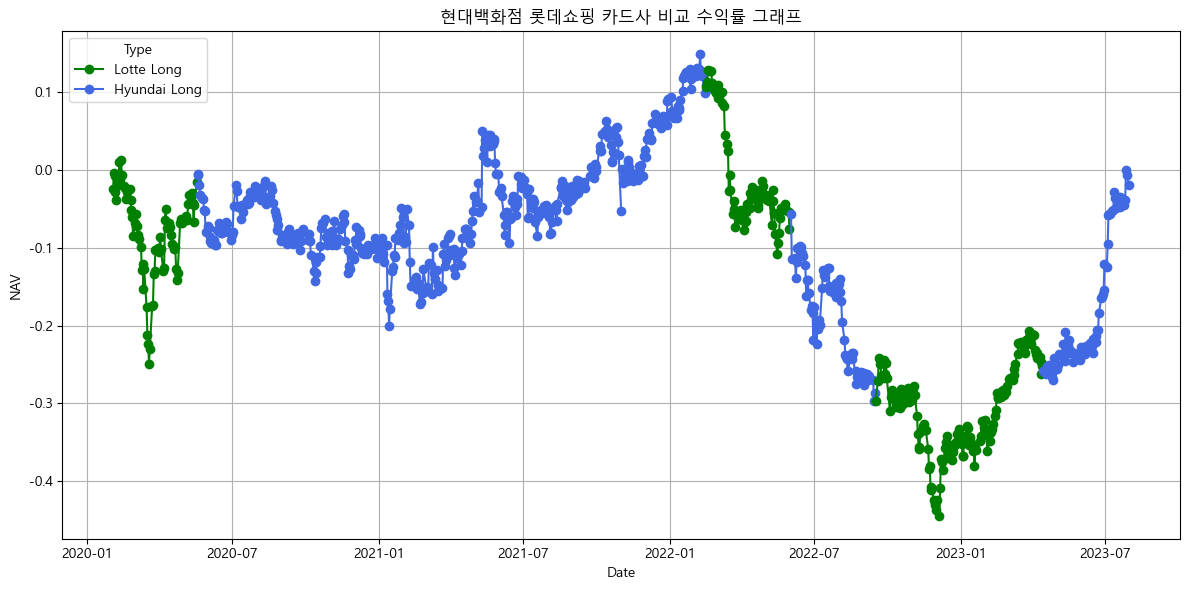

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# 빈 데이터프레임 생성
combined_df = pd.DataFrame()

# 파일을 하나씩 읽어와서 데이터프레임에 추가
for i in range(1, 13):
    file_name = f"close_hl{i}.csv"
    df = pd.read_csv(file_name, parse_dates=['transaction_date'])
    df['type'] = 'Lotte Long' if i % 2 == 1 else 'Hyundai Long'  # 홀수는 롯데 롱, 짝수는 현대 롱
    combined_df = pd.concat([combined_df, df])

# 필요한 전처리 수행
combined_df.dropna(subset=['return'], inplace=True)

# 파일을 구간별로 나누어 그래프 그리기
plt.figure(figsize=(12, 6))
start_index = 0
colors = {'Hyundai Long': 'royalblue', 'Lotte Long': 'green'}  # 각 타입에 대한 색상 지정
for i in range(1, 13):
    end_index = i * len(combined_df) // 12
    segment_df = combined_df.iloc[start_index:end_index]
    type_name = segment_df['type'].iloc[0]  # 현재 구간의 타입 가져오기
    marker = 'o'  # marker를 설정하여 모든 그룹에 대해 점으로 표시
    plt.plot(segment_df['transaction_date'], segment_df['return'], label=f'Segment {i}', color=colors[type_name], marker=marker)
    start_index = end_index

# 범주 추가
plt.legend(title='Type', loc='upper left', labels=list(reversed(sorted(colors.keys()))))  # 롯데 롱이 먼저 표시되도록 범주를 역순으로 정렬하여 표시

plt.xlabel('Date')
plt.ylabel('NAV')
plt.title('현대백화점 롯데쇼핑 카드사 비교 수익률 그래프')
plt.grid(True)
plt.tight_layout()
plt.show()


참고들

In [25]:
import matplotlib.pyplot as plt

# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
# 폰트 설정
plt.rcParams['font.family'] = 'Arial'

In [ ]:
close_dm = pd.read_csv('card_data_(daesung,mega).csv', parse_dates=['transaction_date'])
close_dm = close_dm[['transaction_date', 'mandata_brand_name']]
m_df = close_dm[close_dm['mandata_brand_name'] == 'MEGASTUDYCO LTD_ALL']
d_df = close_dm[close_dm['mandata_brand_name'] == 'DIGITAL DAESUNG CO LTD_ALL']

m_df = m_df.sort_values(by='transaction_date')
d_df = d_df.sort_values(by='transaction_date')

next_month_date = m_df['transaction_date'].iloc[-1] + pd.offsets.MonthBegin(1)

new_data = {
    'transaction_date': pd.date_range(start=next_month_date, periods=31),
    'mandata_brand_name': ['MEGASTUDYCO LTD_ALL'] * 31
}
new_data2 = {
    'transaction_date': pd.date_range(start=next_month_date, periods=31),
    'mandata_brand_name': ['DIGITAL DAESUNG CO LTD_ALL'] * 31
}

new_rows_df = pd.DataFrame(new_data)
new_rows_df2 = pd.DataFrame(new_data2)
m_df = pd.concat([m_df, new_rows_df], ignore_index=True)
d_df = pd.concat([d_df, new_rows_df2], ignore_index=True)

In [ ]:
m_close = fdr.DataReader('072870', '2021-02-01', '2023-07-31') 
m_close = m_close[['Close']]
d_close = fdr.DataReader('068930', '2021-02-01', '2023-07-31') 
d_close = d_close[['Close']]
m_close.to_csv('m_close.csv', index=True)
d_close.to_csv('d_close.csv', index=True)

h_close = fdr.DataReader('069960', '2019-01-31', '2023-07-31') 
h_close = h_close[['Close']]
l_close = fdr.DataReader('023530', '2019-01-31', '2023-07-31') 
l_close = l_close[['Close']]
h_close.to_csv('h_close.csv', index=True)
l_close.to_csv('l_close.csv', index=True)

e_close = fdr.DataReader('139480', '2019-01-31', '2023-07-31') 
e_close = e_close[['Close']]
s_close = fdr.DataReader('004170', '2019-01-31', '2023-07-31') 
s_close = s_close[['Close']]
e_close.to_csv('e_close.csv', index=True)
s_close.to_csv('s_close.csv', index=True)